In [35]:
# Importing Necessary Packages
import networkx as nx
import io
import csv
import numpy as np
import random
import math
from mpmath import mp

In [36]:
# Loading the given network file and finding the number of nodes and edges. 
yt=nx.read_edgelist('/content/drive/MyDrive/XXXXXXX/YouTube.edgelist')
print("Number of nodes :", yt.number_of_nodes())
print("Number of edges :", yt.number_of_edges())
n = yt.number_of_nodes() # n is Number of nodes

Number of nodes : 7675
Number of edges : 35622


In [37]:
# Loading the Groudtruth communites file and appending to a list, where each
# element represents the nodes for each row in the file
act_comm= []
gc=open("/content/drive/MyDrive/XXXXXXX/groundtruth_communities.txt","r")
for row in gc:
  act_comm.append(set(row.strip().split()))
  #print(set(row.strip().split()))
c = len(act_comm)
print("Number of communities:",c)

Number of communities: 29


In [72]:
# Loading the twenty percent seed file into a list of lists
# There are 29 lists and each list has the node values as given in the file
twentyseed=[]
with open ('/content/drive/MyDrive/XXXXXXX/20percent_seed_communities.txt') as csvfile:
  reader=csv.reader(csvfile, delimiter = ' ')
  for row in reader:
    twentyseed.append(row)

In [120]:
# Loading the Neigborhood seed  file into a list of lists
# There are 29 lists and each list has the node values as given in the file
neigseed=[]
with open ('/content/drive/MyDrive/XXXXXXX/neighborhood_seeds.txt') as csvfile:
  reader=csv.reader(csvfile, delimiter = ' ')
  for row in reader:
    neigseed.append(row)

In [38]:
# Setting threshold as given in the instructions
e = math.exp(10^(-8))
t = np.sqrt(-(math.log(1-e)))
t # t is threshold value

0.0009118821551182842

In [116]:
# Method to find the detected communities by initializing according to 20percent seed file 
# Method 1: 20 percent seed community file
# Input : No of iterations and learning rate
# Output : A tuple of Average recall value and a nested dictiionary of best matched detected communities with avg recall value
def meth1(Iterations,learning_rate):
  initialized_matrix = meth1_initialization()
  c_initialized_matrix = fill_with_conductance(initialized_matrix)
  optimized_matrix = matrix_factorization(c_initialized_matrix,Iterations,learning_rate)
  assigned_communites = assign_memberships(optimized_matrix)
  detected_communites = detect_community_by_recall(assigned_communites)
  average_recall = cal_avg_recall(detected_communites)
  return (average_recall,detected_communites)

In [122]:
# Method to find the detected communities by initializing according to Neighborhood seed file 
# Method 2: Neighborhood seed community file
# Input : No of iterations and learning rate
# Output : A tuple of Average recall value and a nested dictiionary of best matched detected communities with avg recall value
def meth2(Iterations,learning_rate):
  initialized_matrix = meth2_initialization()
  c_initialized_matrix = fill_with_conductance(initialized_matrix)
  optimized_matrix = matrix_factorization(c_initialized_matrix,Iterations,learning_rate)
  assigned_communites = assign_memberships(optimized_matrix)
  detected_communites = detect_community_by_recall(assigned_communites)
  average_recall = cal_avg_recall(detected_communites)
  return (average_recall,detected_communites)

In [42]:
# Method to find the detected communities by initializing according to Random Intialization in the range [0,1]
# Method 3: Random Intialization in the range [0,1]
# Input : No of iterations and learning rate
# Output : A tuple of Average recall value and a nested dictiionary of best matched detected communities with avg recall value
def meth3(Iterations,learning_rate):
  initialized_matrix = meth3_initialization()
  optimized_matrix = matrix_factorization(initialized_matrix,Iterations,learning_rate)
  assigned_communites = assign_memberships(optimized_matrix)
  detected_communites = detect_community_by_recall(assigned_communites)
  average_recall = cal_avg_recall(detected_communites)
  return (average_recall,detected_communites)

In [114]:
# Initilization of Method 1: 20 percent seed file
# A nan matrix with (n,c) shape is created with nan values
# Updated nans to 1 whenever (n,c) combination is present in 20percent seed file
# Returning updated factor matrix
def meth1_initialization():
  po2=[[np.nan for i in range(c)] for j in range(n)]
  fact_mat2=np.array(po2)
  for i in range(0,n):
    for j in range(0,len(twentyseed)):
      if str(i) in twentyseed[j]:
        fact_mat2[i,j] = 1
  #c_fact_mat2 = fill_with_conductance(fact_mat2)
  return fact_mat2

In [121]:
# Initilization of Method 2: Neighborhood seed file
# A nan matrix with (n,c) shape is created with nan values
# Updated nans to 1 whenever (n,c) combination is present in Neighborhood seed file
# Returning updated factor matrix
def meth2_initialization():
  po2=[[np.nan for i in range(c)] for j in range(n)]
  fact_mat2=np.array(po2)
  for i in range(0,n):
    for j in range(0,len(neigseed)):
      if str(i) in neigseed[j]:
        fact_mat2[i,j] = 1
  #c_fact_mat2 = fill_with_conductance(fact_mat2)
  return fact_mat2

In [76]:
# Initilization of Method 3: Random Intilization method in the [0,1]
# A nan matrix with (n,c) shape is created with random values in the ranfe of [0,1]
# Returning updated factor matrix
def meth3_initialization():
  po=[[random.randint(0,1000)/1000.0 for i in range(c)] for j in range(n)]
  fact_mat=np.array(po)
  return fact_mat

In [115]:
# For Methods 1 and 2, the nan values(Remaning valyues not filled with seed files)
# is filled using the conductance logic
# Input : Factor Matrix
# Output: Updayed Factor Matrix
def fill_with_conductance(fact_mat2):
  for i in range(0,n): # For each node
    cd = np.inf # Intiliazing first conductance value to infinity
    global local_comm # Declared local community variable
    m = [str(i)]  + list(yt.neighbors(str(i))) # node + its neighbors
    for j in range(0,c): # For each community
      if math.isnan(fact_mat2[i,j]): # If its nan only(because only the remaning values)
        act_cd = nx.conductance(yt, set(m+twentyseed[j])) # Measuring conducatance of node+neighbors+community members
        if act_cd < cd:
          cd = act_cd
          local_comm = j # Updating loca_comm variable as per the comm with lowest conductance vaue
    for z in m: # Looping over node i and neiggbors
      fact_mat2[int(z),local_comm] = 1 # Updating factormatrix[n,local_comm] = 1 where n nelong to node +neighbors
      for j in range(0,len(twentyseed)): # Updating to 0 if not the local_comm
        if (j != local_comm and (math.isnan(fact_mat2[int(z),j]))):
          fact_mat2[int(z),j] = 0
  return fact_mat2 # returninf updated factor matrix

In [44]:
# A method to update each node in factor matrix as per bigclam v2.0 formula
# Input : Completed Initliazed FACTOR mAtrix, number of iterations, learning rate
def matrix_factorization(matrix,Itertions,learning_rate):
  fact_mat = matrix
  lr = learning_rate
  I = Itertions
  for iter in range(0,500):   # Taking max i as 500
    if iter < I or all([q>0.001 for q in all_fu_change]): # Checking if i<I or percentage change of fu for all fu <0.001%
      all_fu_change = []
      #print(iter)
      fw=[0]*c
      for w in fact_mat:
        fw = np.add(fw,w) # Finidnf sigma fw term
      for i in range(0,n): # For each node
        fu = fact_mat[i,] # fu value
        neig = list(yt.neighbors(str(i))) # Getting the list of neigbors
        fv_neig=[0]*c
        first_term = [0]*c
        for j in neig:
          fv_neig=np.add(fv_neig,fact_mat[int(j)]) # Adding all neighbor nodes
          try:
            term = fact_mat[int(j)]*(math.exp(-(np.dot(fu,fact_mat[int(j)])))/(1-math.exp(-(np.dot(fu,fact_mat[int(j)]))))) # first term in gradient equation
          except: #ZeroDivisionError:
            term = 0 #fact_mat[int(j)]*(math.exp(-(np.dot(fu,fact_mat[int(j)]))))
          #print(term)
          first_term = np.add(first_term,term) # Adding all the first terms
        fv_not_neig = np.subtract(np.subtract(fw,fu),fv_neig) # fc not neighbors value calulatio
        grad_fu = np.subtract(first_term,fv_not_neig) # Finiding the fradient
        fu = fu + (grad_fu*lr) # updating fu
        before = np.sum(fact_mat[i,]) # getting the prev values of fu
        for y in range(0,c):
          if fu[y]< 0:
            fact_mat[i,y] = 0 # projecting fu values to if the update value is neagtive
          else:
            fact_mat[i,y] = fu[y]      # if positving, assiging the new values
        after = np.sum(fact_mat[i,]) # getting the updated value of fu
        fu_change = ((after - before)/before)*100  # calculating the percentage change
        all_fu_change.append(fu_change)
  return fact_mat # returning factor matrix after all iterations or if the change in percent <0.001

In [45]:
# Assigning memerbshup to nodes comparing with threhsodl
# Input : Optimized Factor Matrix after Matrix Factorization
# Output : A dictionary of assigned communities as per the threshold
def assign_memberships(factor_matrix):
  fact_mat_trans = factor_matrix.T # Transposing the factor matrix
  pred_comm = []
  for v in range(0,c):
    comm = set()
    for u in range(0,n):
      if fact_mat_trans[v,u] >=t:
        comm.add(str(u))
    pred_comm.append(comm) # appending nodes of each community
  assigned_communties = {}
  for i in range(0,c):
    assigned_communties[i] = pred_comm[i] # indexing the community number as key and pred_comm as value
  return assigned_communties

In [46]:
# A fucntion to detected the best matched community for each groud truth community
# Input : Assigned communities dictionary
# Output: Detected community + recall score fr each ground truth community
# Recall formula = true positives /(true positives/false negatives)
def detect_community_by_recall(assigned_communties):
  all={}
  for a in range(0,c): # For each community in ground truth
    each = []
    recall = -1
    best_match_comm = -1
    for p in range(0,c): # For each in assignec coomunities (As communities may shift positions)
      if p in assigned_communties.keys():
        if len(act_comm[a].intersection(assigned_communties[p]))/len(act_comm[a]) > recall:
          recall = len(act_comm[a].intersection(assigned_communties[p]))/len(act_comm[a]) # as per recall formula
          best_match_comm = p
    each.append(best_match_comm) #appenindg the best matched coounity from assigned 
    each.append(recall) # and its recall score
    all[a] = each
    assigned_communties.pop(best_match_comm) # removing the best matched detected community
  return all # retufing thr final dictionary with gccomm:[deteced comm, recall]

In [47]:
# A method to just give the average recall score
# input detected communities(+recall scores)
#output: average recall score
def cal_avg_recall(detected_communites):
  avg_recall=0
  for i in range(0,c):
    avg_recall+=detected_communites[i][1]
  return avg_recall/c

In [ ]:
# Calling Methods

In [ ]:
meth1_results = meth1(350,0.00001)
meth2_results = meth2(350,0.00001)
meth3_results = meth3(350,0.000001)

In [160]:
# Printing Recall scores of each method
print("Average Recall Score for Method 1: Initializing with 20 percent seed file : ", round(meth1_results[0],2))
print("Average Recall Score for Method 2: Initializing with Neighborhood seed file : ", round(meth2_results[0],2))
print("Average Recall Score for Method 3: Initializing with Random Intialization values in [0,1] : ", round(meth3_results[0],2))

Average Recall Score for Method 1: Initializing with 20 percent seed file :  0.67
Average Recall Score for Method 2: Initializing with Neighborhood seed file :  0.63
Average Recall Score for Method 3: Initializing with Random Intialization values in [0,1] :  0.51


In [169]:
# Outputting Detected Communities for each method to csv files
# Format : Ground Truth Community : Detected Community 
field_names= ['Groundtruth Community', 'Detected Community : Average Recall Score']

# Method 1: Output
a_file = open("/content/drive/MyDrive/XXXXXXXXX/method1_detected_communities.csv", "w")
a_dict = meth1_results[1]

writer = csv.writer(a_file)
for key, value in a_dict.items():
    writer.writerow([key, value])

a_file.close()

# Method 2 output
a_file = open("/content/drive/MyDrive/XXXXXXXXXXXXXX/method2_detected_communities.csv", "w")
a_dict = meth2_results[1]

writer = csv.writer(a_file)
for key, value in a_dict.items():
    writer.writerow([key, value])

a_file.close()

# Method 3 output
a_file = open("/content/drive/MyDrive/XXXXXXXXXXXX/method3_detected_communities.csv", "w")
a_dict = meth3_results[1]

writer = csv.writer(a_file)
for key, value in a_dict.items():
    writer.writerow([key, value])

a_file.close()

In [ ]:
# Plots

In [144]:
# Getting the count of how many communities actually matched with the ground truth for all the three methods
def get_mat_commu_count(meth_results):
  matched_commu_count = 0
  for k,v in meth_results[1].items():
    if k == v[0]:
      matched_commu_count+=1
  return matched_commu_count
f = []
f.append(get_mat_commu_count(meth1_results))
f.append(get_mat_commu_count(meth2_results))
f.append(get_mat_commu_count(meth3_results))

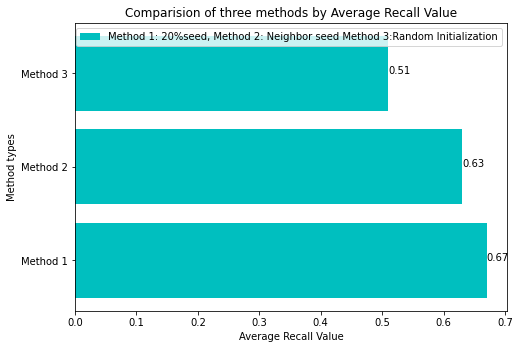

In [149]:
# PLotting the average recall score for all the 3 methods
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
methods = ['Method 1', 'Method 2', 'Method 3']
avg_recall = [round(meth1_results[0],2),round(meth2_results[0],2),round(meth3_results[0],2)]
plt.barh(methods, avg_recall, color = 'c', label='Method 1: 20%seed, Method 2: Neighbor seed Method 3:Random Initialization')
plt.xlabel('Average Recall Value')
plt.ylabel('Method types')
plt.title("Comparision of three methods by Average Recall Value")
plt.legend(loc='best')
for index, value in enumerate(avg_recall):
    plt.text(value, index, str(value))
plt.show()

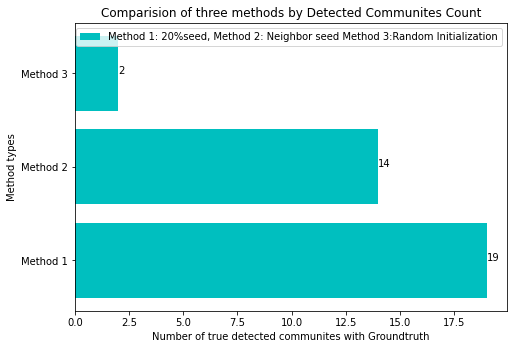

In [154]:
# Plotting the number of matched detected communites for each methos
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
methods = ['Method 1', 'Method 2', 'Method 3']
matched_comm_count = f
plt.barh(methods, matched_comm_count, color = 'c', label='Method 1: 20%seed, Method 2: Neighbor seed Method 3:Random Initialization')
plt.xlabel('Number of true detected communites with Groundtruth')
plt.ylabel('Method types')
plt.title("Comparision of three methods by Detected Communites Count")
plt.legend(loc='best')
for index, value in enumerate(matched_comm_count):
    plt.text(value, index, str(value))
plt.show()

# Comparision and Contrast of the models using plots
From the visualizations of the 2plots, it can be observed that method 1 has best results. As its average recall score is 0.67 and it has the highest number of matched detected communitues. The second place is taken by method 3 with a recall of 0.63 and the second best mathched detected communities. The least place is taken by method 1 with a recall of 0.53.

It can be said , the performance of method 1(20% seed initialization) > method 2(neighborhood seed initilization) > method 3( random initilization [0,1])